<a href="https://colab.research.google.com/github/Shifatasmiah/Diabetic-Retinopathy-Classification/blob/main/MobileNetLarge_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
import pathlib
import pickle
from sklearn.model_selection import KFold

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Diabetic retinopathy classification/retinadataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

399


In [ ]:
img_height, img_width = 224, 224
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 399 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
total_classes = len(class_names)
print(total_classes)
print(class_names)

6
['Hypertensive retinopathy', 'Mild NPDR (1)', 'Moderate NPDR (2)', 'NO_DR 0', 'Proliferative DR 4', 'Severe NPDR 3']


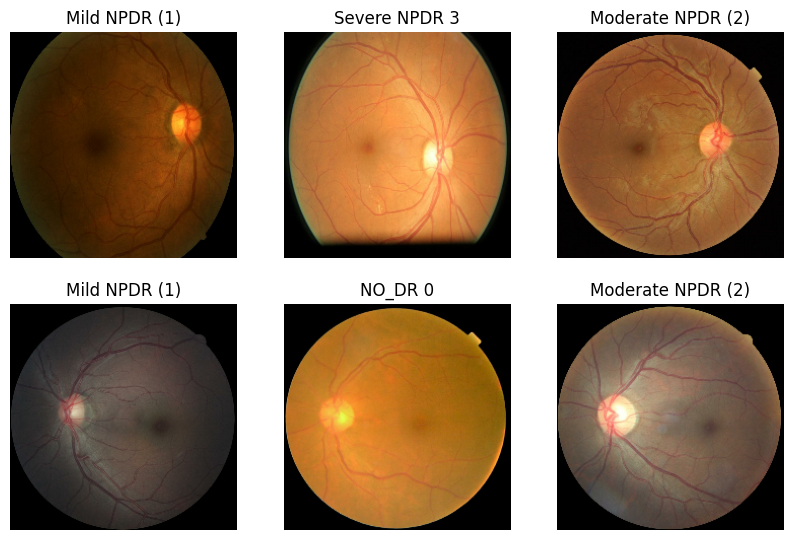

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

dataset = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# convert it to one hot encoded
dataset = dataset.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

In [ ]:
# checkpoint and monitor val_accuracy val_precision val_recall val_f1_score
model_name = 'MobileNetV3Large'
checkpoint_filepath = '/content/drive/MyDrive/Diabetic_retinopathy/training_checkpoints/' + model_name + '.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    period=25
)

In [ ]:
history_list = []
history_file = "/content/drive/MyDrive/Diabetic_retinopathy/training_history/" + model_name + ".pkl"
if os.path.exists(history_file):
    with open(history_file, "rb") as f:
        history_list = pickle.load(f)
else:
    history_list = []

In [ ]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),

    ])

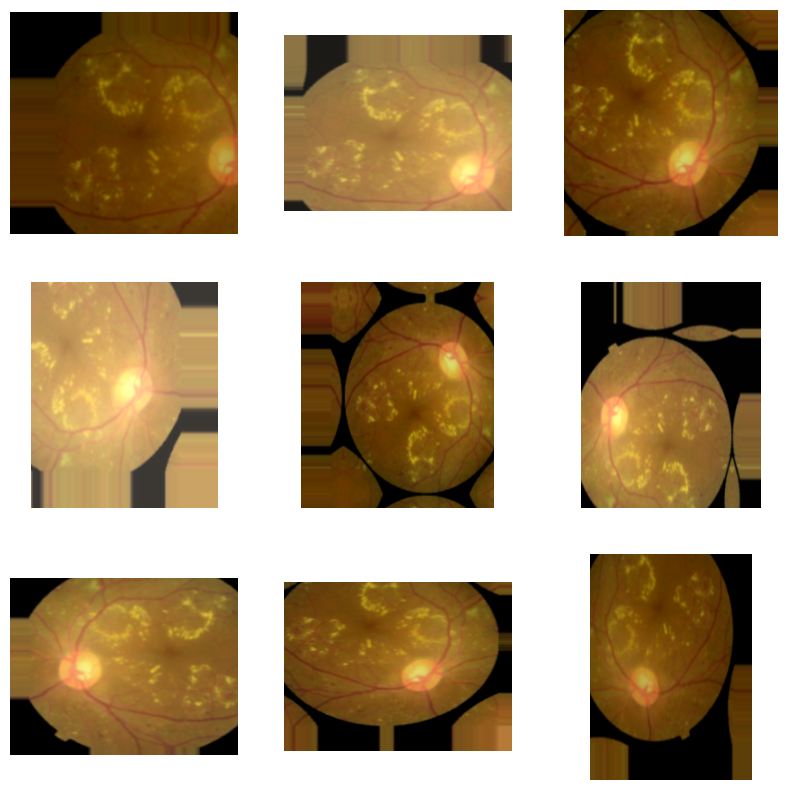

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in dataset.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[3].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 28.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
if os.path.exists(checkpoint_filepath):
    # Load the model from the checkpoint file
    model = tf.keras.saving.load_model(checkpoint_filepath)
    print("Model loaded from checkpoint.")
else:
    pretrained_model = tf.keras.applications.MobileNetV3Large(include_top=False,
                                                            input_shape=(
                                                                img_height, img_width, 3),
                                                            pooling='avg', classes=total_classes,
                                                            weights='imagenet')

    for layer in pretrained_model.layers[:-10]:
        layer.trainable = False


    model = Sequential([
        data_augmentation,
        layers.Lambda(tf.keras.applications.mobilenet_v3.preprocess_input),
        pretrained_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dense(total_classes, activation='softmax'),
    ])

    model.build((None, img_height, img_width, 3))

model.summary()

12683000/12683000 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 512)               492032    
                                                                 
 dense_1 (Dense)             (None, 6)                 

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tfa.metrics.F1Score(total_classes,name = 'f1_score')
])

In [ ]:
train_images = []
train_labels = []
for images, labels in dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=123)

fold = 1
for train_index, val_index in kf.split(train_images):
    print(f"Training fold: {fold}")
    x_train, x_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]
    train_fold = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    val_fold = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

    epochs = 100
    history = model.fit(
    train_fold,
    validation_data=val_fold,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    )

    fold += 1

    history_list.append(history.history)

with open(history_file, "wb") as f:
    pickle.dump(history_list, f)


Training fold: 1
Epoch 1/100
10/10 [==============================] - 35s 2s/step - loss: 1.9493 - accuracy: 0.3197 - precision: 0.3670 - recall: 0.1254 - f1_score: 0.2521 - val_loss: 1.4071 - val_accuracy: 0.4500 - val_precision: 0.6897 - val_recall: 0.2500 - val_f1_score: 0.3260
Epoch 2/100
10/10 [==============================] - 5s 438ms/step - loss: 1.3288 - accuracy: 0.4953 - precision: 0.6271 - recall: 0.2320 - f1_score: 0.4808 - val_loss: 1.8373 - val_accuracy: 0.3625 - val_precision: 0.3607 - val_recall: 0.2750 - val_f1_score: 0.2480
Epoch 3/100
10/10 [==============================] - 5s 511ms/step - loss: 1.1883 - accuracy: 0.5329 - precision: 0.6711 - recall: 0.3197 - f1_score: 0.5123 - val_loss: 2.6697 - val_accuracy: 0.3375 - val_precision: 0.3611 - val_recall: 0.3250 - val_f1_score: 0.1663
Epoch 4/100
10/10 [==============================] - 5s 508ms/step - loss: 1.0915 - accuracy: 0.5549 - precision: 0.6721 - recall: 0.3856 - f1_score: 0.5747 - val_loss: 3.2189 - val_ac

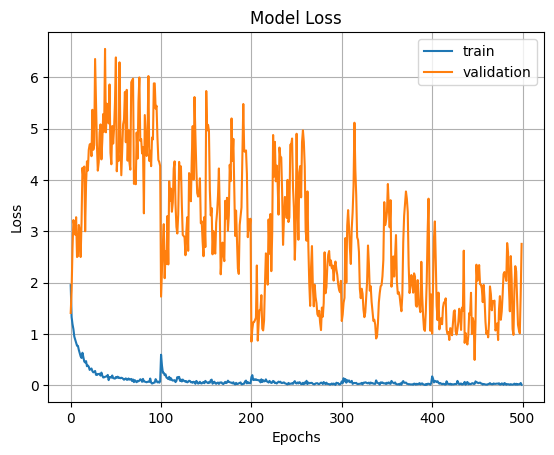

In [ ]:
combined_history = {}
for metric in history_list[0].keys():
    combined_history[metric] = []
    for hist in history_list:
        combined_history[metric].extend(hist[metric])

# Plot the combined history
plt.plot(combined_history['loss'])
plt.plot(combined_history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

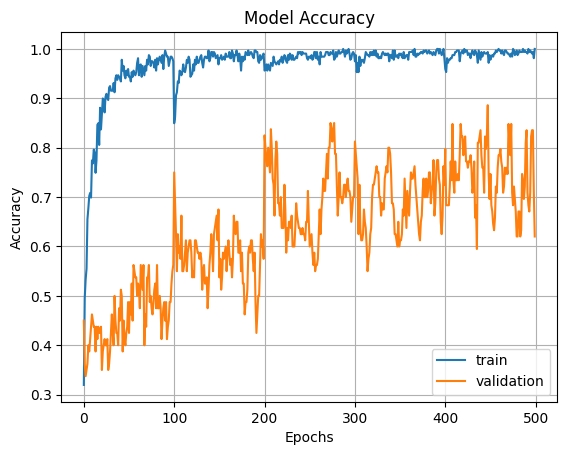

In [ ]:
plt.plot(combined_history['accuracy'])
plt.plot(combined_history['val_accuracy'])
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

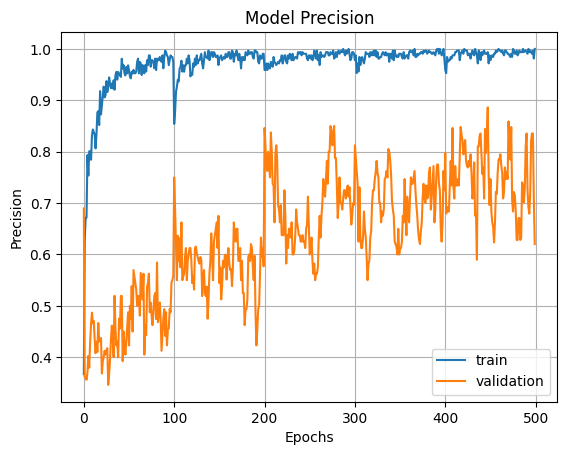

In [ ]:
plt.plot(combined_history['precision'])
plt.plot(combined_history['val_precision'])
plt.grid()
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

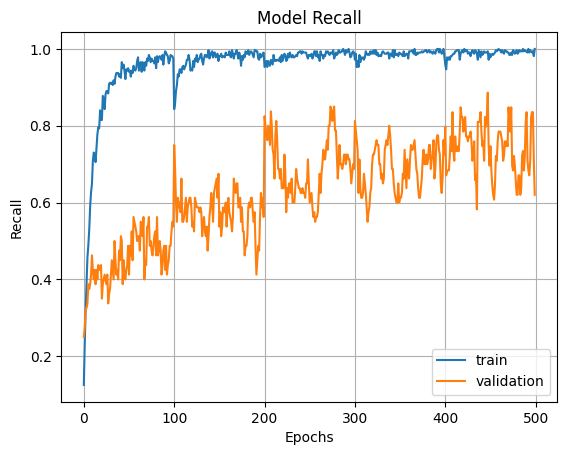

In [ ]:
plt.plot(combined_history['recall'])
plt.plot(combined_history['val_recall'])
plt.grid()
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
test_data_dir = '/content/drive/MyDrive/testdata/testdata'
test_data_dir = pathlib.Path(test_data_dir)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# convert it to one hot encoded
test_dataset = test_dataset.map(lambda x, y: (x, tf.one_hot(y, total_classes)))

test_images = []
test_labels = []
for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


Found 84 files belonging to 6 classes.


In [ ]:
predictions = model.predict(test_images)


3/3 [==============================] - 2s 411ms/step


In [ ]:
test_labels = np.argmax(test_labels, axis=-1)
predictions = np.argmax(predictions, axis=-1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')
f1 = f1_score(test_labels, predictions, average='macro')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1-Score: {f1}")


Test Accuracy: 0.8571428571428571
Test Precision: 0.9020872338950143
Test Recall: 0.8560606060606061
Test F1-Score: 0.8561380929801982


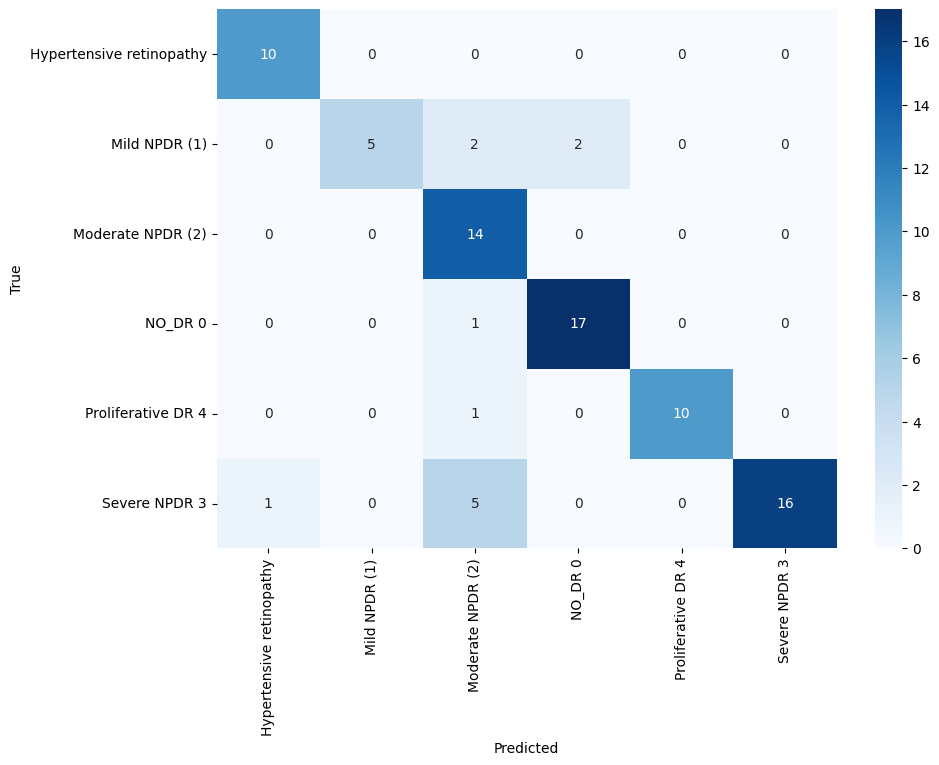

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# predicting classes using the model
y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# calculating precision, recall, f1-score and support
classification_metrics = classification_report(y_true, y_pred_classes, target_names=class_names)

print(classification_metrics)


3/3 [==============================] - 0s 33ms/step
                          precision    recall  f1-score   support

Hypertensive retinopathy       0.67      1.00      0.80         2
           Mild NPDR (1)       1.00      0.30      0.46        20
       Moderate NPDR (2)       0.33      0.92      0.49        12
                 NO_DR 0       0.68      0.87      0.76        15
      Proliferative DR 4       1.00      0.57      0.73        14
           Severe NPDR 3       0.90      0.56      0.69        16

                accuracy                           0.62        79
               macro avg       0.76      0.70      0.66        79
            weighted avg       0.81      0.62      0.63        79

